In [1]:
import json
from itertools import product

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
qwenvl_res_json = json.load(open("/data1/home/ohs/workspace/rai/eval_results/qwenvl_results.json", "r"))


cuts = ["half_cut", "third_cut", "quarter_cut"]
tan_idxes = [0, 1, 2, 3]


cut_tans = ["_".join([cut, str(tan_idx)]) for cut, tan_idx in product(cuts, tan_idxes)]
header = ["idx"] + cut_tans

res_df = pd.DataFrame(columns=header)

for idx, res in qwenvl_res_json.items():
    res_df.loc[len(res_df)] = [idx] + [res[cut_tan]["normed_ed"] for cut_tan in cut_tans]

averages = {}
for cut_tan in cut_tans:
    cut_tan_res = res_df[cut_tan].to_list()
    clipped_result = [res if res < 1.0 else 1.0 for res in cut_tan_res]
    clipped_result = [res if res > 0.0 else 0.0 for res in clipped_result]

    avg = sum(clipped_result) / len(clipped_result)
    averages[cut_tan] = avg
    
avg_df = pd.DataFrame.from_dict(averages, orient="index", columns=["avg"]).reset_index()

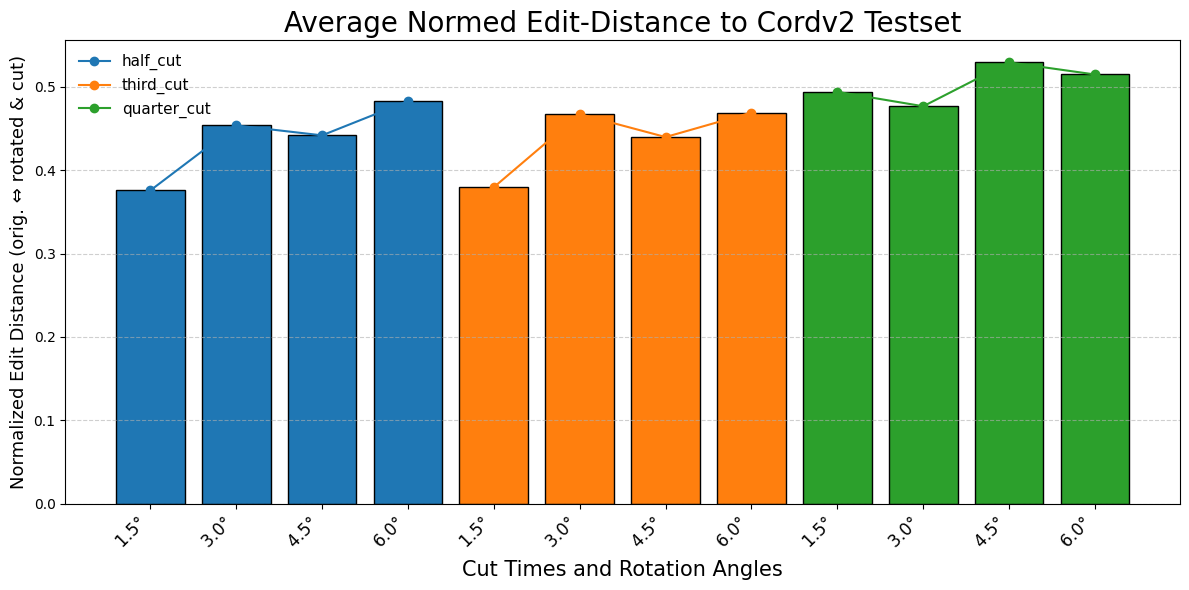

In [11]:
avg_map = dict(zip(avg_df["index"], avg_df["avg"]))
y_vals  = [avg_map[ct] for ct in cut_tans]

color_map = {
    "half_cut"   : "tab:blue",
    "third_cut"  : "tab:orange",
    "quarter_cut": "tab:green",
}

x_pos   = np.arange(len(cut_tans))
bar_w   = 0.8

fig, ax = plt.subplots(figsize=(12, 6))

group_x, group_y = {cut: [] for cut in cuts}, {cut: [] for cut in cuts}

for i, ct in enumerate(cut_tans):
    cut_name = ct.rsplit("_", 1)[0]
    color    = color_map[cut_name]
    
    ax.bar(x_pos[i], y_vals[i], width=bar_w, color=color, edgecolor="black")
    
    group_x[cut_name].append(x_pos[i])
    group_y[cut_name].append(y_vals[i])

for cut in cuts:
    ax.plot(group_x[cut], group_y[cut],
            marker="o", linestyle="-", linewidth=1.5,
            color=color_map[cut], label=cut if cut not in ax.get_legend_handles_labels()[1] else "_nolegend_")

angles = ["1.5\N{DEGREE SIGN}", "3.0\N{DEGREE SIGN}", "4.5\N{DEGREE SIGN}", "6.0\N{DEGREE SIGN}"]
xticklabels = [" ".join(["", angle]) for cut, angle in product(cuts, angles)]
ax.set_xticks(x_pos)
ax.set_xticklabels(xticklabels, rotation=45, ha="right", fontsize=12)
ax.set_xlabel("Cut Times and Rotation Angles", fontsize=15)
ax.set_ylabel("Normalized Edit Distance (orig. ⇔ rotated & cut)", fontsize=13)
ax.set_title("Average Normed Edit-Distance to Cordv2 Testset", fontsize=20)
ax.grid(axis="y", linestyle="--", alpha=0.6)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="", frameon=False, fontsize=11)

plt.tight_layout()
plt.show()